# DenseNet121
## Detección de múltiples enfermedades en Radiografías de Tórax


# 1. Preparación de los datos
Lo que se busca en esta fase es transformar y limpiar la información que existe en el dataset y que con ello genere mayor valor al ingresar al modelo de inteligencia artificial.

Empezaremos por leer los archivos y directorios con los que interactuará el Notebook.


In [1]:
import os
try:
    inpath = "../input/data/" #Kaggle
    print(os.listdir(inpath))
except FileNotFoundError:
    inpath = "./" #Local
    print(os.listdir(inpath))

['images_008', 'images_011', 'images_007', 'test_list.txt', 'images_004', 'images_012', 'train_val_list.txt', 'images_002', 'Data_Entry_2017.csv', 'images_010', 'images_006', 'LOG_CHESTXRAY.pdf', 'BBox_List_2017.csv', 'FAQ_CHESTXRAY.pdf', 'images_009', 'README_CHESTXRAY.pdf', 'ARXIV_V5_CHESTXRAY.pdf', 'images_003', 'images_005', 'images_001']


Usaremos la librería Pandas para leer el archivo csv que relaciona las imágenes con la información del paciente. La estructura que nos retorna Pandas es llamada dataFrame, este tipo de estructura, la usaremos en varios puntos del proceso.

In [2]:
import pandas as pd
data = pd.read_csv(inpath + 'Data_Entry_2017.csv')
print(f"Las dimensiones del conjunto de datos son: {data.shape}")

data.head()

Las dimensiones del conjunto de datos son: (112120, 12)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


### Limpieza de Datos



Para nuestro proceso de limpieza efectuaremos las siguientes tareas:

* Eliminaremos los pacientes con una edad mayor a 100 años, debido a que pueden presentar deterioro en todo su cuerpo a causa de su edad.

In [3]:
data = data[data['Patient Age']<100]

print(f"Las dimensiones del conjunto de datos son: {data.shape}")

Las dimensiones del conjunto de datos son: (112104, 12)


In [ ]:
data.groupby('Patient ID').nunique()

* Seleccionamos solamente las columnas necesarias para nuestro proyecto

In [4]:
data = data[['Image Index', 'Finding Labels']]

print(f"Las dimensiones del conjunto de datos son: {data.shape}")

Las dimensiones del conjunto de datos son: (112104, 2)


### Generación de la ruta absoluta de cada imagen

Usaremos la ruta absoluta de cada imagen para construir el objeto que alimentará a la red neuronal convolucional. En este punto se itera sobre cada archivo en el directorio de imagenes, el cual se basa del Dataset NIH Chest X-rays, sobre el cual se ha realizado una redimensión a 224px * 224px

In [5]:

#Leemos todas las rutas de las imagenes

from glob import glob
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('..', 'input', 'data', 'images*', '*', '*.png'))}
print('Imágenes encontradas:', len(all_image_paths))

"""
Agregamos la columna path al conjunto de datos
"""
data['Path'] = data['Image Index'].map(all_image_paths.get)

data.sample(5, random_state=3)

Imágenes encontradas: 112120


,Image Index,Finding Labels,Path
13531,00003520_002.png,No Finding,../input/data/images_002/images/00003520_002.png
45241,00011598_037.png,Effusion|Mass,../input/data/images_006/images/00011598_037.png
40313,00010503_000.png,Infiltration,../input/data/images_005/images/00010503_000.png
81272,00019962_006.png,No Finding,../input/data/images_009/images/00019962_006.png
85415,00021047_013.png,No Finding,../input/data/images_010/images/00021047_013.png


Para algunos procesos más adelante necesitaremos generar una lista de todas las etiquetas (enfermedades) presentes en el conjunto de datos, para ello, nos apoyaremos en la librería numpy la cual nos ofrece herramientas de procesamiento de datos, algebra lineal entre otras cosas.

In [6]:

#Se crea a numpy array con todas las enfermedades

import numpy as np
from itertools import chain
all_labels = np.unique(list(chain(*data['Finding Labels'].map(lambda x: x.split('|')).tolist())))

all_labels

array(['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration',
       'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia',
       'Pneumothorax'], dtype='<U18')

Además de ello, eliminaremos la etiqueta “No Finding” (Sin enfermedad) con la intención de representar una radiografía sin enfermedad como la ausencia de etiquetas. Finalmente convertiremos la lista de enfermedades de un tipo numpy array a una list primitiva de Python.

In [7]:
all_labels = np.delete(all_labels, np.where(all_labels == 'No Finding'))
print(f'Tipo actual: {type(all_labels)}')

all_labels = [x for x in all_labels]
print(f'Tipo final: {type(all_labels)}')

print(f'Enfermedades: ({len(all_labels)}): {all_labels}')

Tipo actual: <class 'numpy.ndarray'>
Tipo final: <class 'list'>
Enfermedades: (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


### One Hot Encoding

Utilizaremos el proceso de One Hot Encoding para generar una columna por cada enfermedad, dicha columna será llenada con "1" si la imagen en cuestión posee dicha enfermedad y "0" si no la posee, esto quiere decir, que una imagen sin enfermedad tendrá todas las columnas de enfermedad en "0".

In [8]:
# Agregamos una columna, por cada enfermedad

for c_label in all_labels:
    if len(c_label)>1: # se omite las etiquetas vacias
        data[c_label] = data['Finding Labels'].map(lambda finding: 1 if c_label in finding else 0)
        
print(f"Las dimensiones del conjunto de datos son: {data.shape}")
data.head()

Las dimensiones del conjunto de datos son: (112104, 17)


,Image Index,Finding Labels,Path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,../input/data/images_001/images/00000001_000.png,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,../input/data/images_001/images/00000001_001.png,0,1,0,0,0,1,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,../input/data/images_001/images/00000001_002.png,0,1,0,0,1,0,0,0,0,0,0,0,0,0
3,00000002_000.png,No Finding,../input/data/images_001/images/00000002_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,00000003_000.png,Hernia,../input/data/images_001/images/00000003_000.png,0,0,0,0,0,0,0,1,0,0,0,0,0,0


Estas son algunas de las cantidades de imágenes por enfermedad o grupo de enfermedades, este conteo se realiza agrupando todas enfermedades y combinaciones de ellas presentes en el conjunto de datos:

In [9]:
label_counts = data['Finding Labels'].value_counts()
label_counts

No Finding                                                        60353
Infiltration                                                       9546
Atelectasis                                                        4214
Effusion                                                           3955
Nodule                                                             2705
                                                                  ...  
Atelectasis|Hernia|Mass                                               1
Effusion|Pneumothorax|Pneumonia                                       1
Effusion|Fibrosis|Infiltration|Pleural_Thickening|Pneumonia           1
Infiltration|Mass|Nodule|Pleural_Thickening|Effusion|Pneumonia        1
Consolidation|Infiltration|Nodule|Pneumothorax                        1
Name: Finding Labels, Length: 836, dtype: int64

Almacenaremos solamente las etiquetas o combinaciones de ellas que tengan 12 o más registros (imágenes), esto con la intención de facilitar el proceso de segmentación de los datos.

In [10]:
data = data.groupby('Finding Labels').filter(lambda x : len(x)>11)

In [11]:
label_counts = data['Finding Labels'].value_counts()
print(label_counts.shape)
label_counts

(198,)


No Finding                                                      60353
Infiltration                                                     9546
Atelectasis                                                      4214
Effusion                                                         3955
Nodule                                                           2705
                                                                ...  
Consolidation|Infiltration|Pneumonia                               13
Atelectasis|Cardiomegaly|Consolidation|Effusion|Infiltration       12
Atelectasis|Nodule|Pleural_Thickening                              12
Cardiomegaly|Consolidation|Infiltration                            12
Effusion|Emphysema|Infiltration|Pneumothorax                       12
Name: Finding Labels, Length: 198, dtype: int64

### Segmentación de los datos

Para este proceso usaremos la librería sklearn la cual nos provee herramientas para análisis y minado de data.
Se realizará una segmentación tradicional la cual separa el conjunto de datos en tres: Entrenamiento (training), Validación (validation) y Prueba (test) siguiendo el siguiente flujo:

1. Separaremos el conjunto de datos en Entrenamiento y Prueba, 70% y 30% respectivamente.
2. Del subconjunto de Entrenamiento, tomamos el 30% para generar el subconjunto de Validación.

Esta librería se encarga de mantener una adecuada proporción de las clases en cada uno de los subconjuntos generados.

In [12]:
from sklearn.model_selection import train_test_split

train_and_valid_df, test_df = train_test_split(data,
                                               test_size = 0.30,
                                               random_state = 2018,
                                              )

train_df, valid_df = train_test_split(train_and_valid_df,
                                      test_size=0.30,
                                      random_state=2018,
                                     )

print(f'Entrenamiento {train_df.shape[0]} Validación {valid_df.shape[0]} Prueba: {test_df.shape[0]}')

Entrenamiento 54091 Validación 23183 Prueba: 33118


In [ ]:
# execute just once
train_df.to_csv('train_df.csv',index=False)
valid_df.to_csv('valid_df.csv',index=False)
test_df.to_csv('test_df.csv',index=False)

### Creación del generador de Imagenes

En este punto crearemos el objeto ImageDataGenerator el cual nos permite generar un flujo de imágenes junto con sus etiquetas (DataFrameIterator) para que puedan ser consumidas por el modelo. Además de ello nos permite realizar algunas transformaciones sobre la imágen, en este caso realizaremos un reescalado con la intención de llevar los valores de los píxeles entre 0 y 1 y de esta forma facilitar el aprendizaje del modelo.

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
base_generator = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

Crearemos una función llamada **flow_from_dataframe** en la cual encapsulamos las configuraciones generales, necesarias para la creación de cada uno de los DataFrameIterator necesarios para el proceso de entrenamiento y pruebas.

Usaremos cada subconjunto de datos, para crear un DataFrameIterator.

Dentro de las configuraciones generales tenemos:

* El parametro **x_col** el cual tendrá la columna en donde almacenamos todas las rutas absolutas de las imágenes
* El parametro **y_col** el cual contendrá la lista de columnas con la cual se creará el vector etiqueta de cada imagen, este proceso se apoya del One Hot Encoding realizado previamente.
* El parametro **target_size** en el cual pondremos las dimensiones de la imagen (podríamos poner un valor menor, si quisiéramos realizar una redimensión en este punto)
* El parametro **classes** el cual contendrá una lista de todas las etiquetas únicas presentes en el conjunto de datos. (es la misma lista de **y_col**)
* El parametro **color_mode** en este punto trabajaremos en un modo de color RGB debido a que queremos trabajar Transfer learning, apoyados en los resultados de los modelos sobre el conjunto de datos de Imagenet y dicho conjunto de datos cuenta únicamente con imágenes en RGB.
* El parametro **class_mode** usaremos el modo raw, el cual nos permite generar el vector **y_col** a partir de columnas del DataFrame
* El parametro **shuffle** se configura en falso, para que el entrenamiento se realice en el mismo orden en que encuentran los datos en el DataFrame

In [14]:
IMG_SIZE = (224, 224)
def flow_from_dataframe(image_generator, dataframe, batch_size):

    df_gen = image_generator.flow_from_dataframe(dataframe,
                                                 x_col='Path',
                                                 y_col=all_labels,
                                                 target_size=IMG_SIZE,
                                                 classes=all_labels,
                                                 color_mode='rgb',
                                                 class_mode='raw',
                                                 shuffle=False,
                                                 batch_size=batch_size)
    
    return df_gen

Para cada DataFrameIterator tendremos los siguientes parámetros configurables
* El **generador** el cual puede modificarse para crear el iterador de Entrenamiento utilizando técnicas de aumento de datos.
* El **DataFrame** a partir del cual crearemos el generador.
* El **batch_size** el cual hace referencia a la cantidad de imágenes que recibirá el modelo de forma simultánea. Este valor puede aumentar el uso de recurso de cómputo.

In [15]:
train_gen = flow_from_dataframe(image_generator=base_generator, 
                                dataframe= train_df,
                                batch_size = 32)

valid_gen = flow_from_dataframe(image_generator=base_generator, 
                                dataframe=valid_df,
                                batch_size = 32)

test_gen = flow_from_dataframe(image_generator=base_generator, 
                               dataframe=test_df,
                               batch_size = 32)

/opt/conda/lib/python3.6/site-packages/keras_preprocessing/image/dataframe_iterator.py:211: UserWarning: `classes` will be ignored given the class_mode="raw"
  .format(self.class_mode))


Found 54091 validated image filenames.
Found 23183 validated image filenames.
Found 33118 validated image filenames.


En este punto podemos evidenciar, que el DataFrameIterator posee para cada una de sus iteraciones una tupla conformada por la matriz de píxeles de la imagen y el vector que hace referencia a las enfermedades que posee la imagen.

In [16]:
train_x, train_y = next(train_gen)
print(f"Dimensiones de la imagen: {train_x[1].shape}")
print(f"Vector de enfermedades: {train_y[1]}")

Dimensiones de la imagen: (224, 224, 3)
Vector de enfermedades: [0 0 0 0 0 0 0 0 0 0 0 0 0 0]


# 2. Modelado

En este punto crearemos el modelo que vamos a implementar con el uso de la líbreria Keras, y también nos provee modelos de redes neuronales

En este caso utilizaremos Keras sobre Tensorflow

### Creación del Modelo[](http://)

La estructura del modelo que se va a probar es la siguiente:

* La base del modelo es la arquitectura (aplicación) seleccionada la cual posee las siguientes configuraciones:
    * **Include_top**: el cual va a estar en false debido a que deseamos agregar nuestra propia capa de predicciones con las 14 salidas que poseemos.
    * **Input_shape**: en el cual almacenaremos las dimensiones de las imágenes que usaremos
    * **Pooling:** en este caso usaremos “avg” para que realice una agrupación de la salida del último bloque convolucional y de esta forma facilitar el proceso de la capa densa que agregaremos inmediatamente después.
    * **Weights:** los pesos en este caso serán los de ‘imagenet’, en este punto podemos afirmar que realizamos un proceso de **Transfer Learning**
    
* Una capa densa la cual nos permitirá obtener las predicciones de nuestra CNN, esta capa recibe:
    * La cantidad de salidas que esperamos que en este caso es 14, la misma cantidad de etiquetas que deseamos clasificar
    * una función de activación sigmoid la cual es la más aconsejada tipo de problemas, la cual nos retorna valores entre 0 y 1 (para cada una de las etiquetas a clasificar)
    
Esto significa que una predicción de nuestra CNN va a ser similar a nuestro vector de enfermedades, con la diferencia de que no lo encontraremos con valores binarios 0 o 1 sino que lo encontraremos con valores entre 0 y 1, en donde los más cercanos a 1 nos van a indicar que la predicción se inclina más por ese tipo de etiqueta o etiquetas a la hora de la clasificación.

In [ ]:
from keras.layers import Input
from keras.applications.densenet import DenseNet121
from keras.layers import Dense
from keras.models import Model


input_shape=(224, 224, 3)
img_input = Input(shape=input_shape)

base_model = DenseNet121(include_top=False, input_tensor=img_input, input_shape=input_shape, 
                         pooling="avg", weights='imagenet')
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))
#multi_disease_model.add(Conv2D(1024, kernel_size=(2,2), activation='sigmoid',input_shape =  t_x.shape[1:]))
model.add(Dense(512))
model.add(Dropout(0.3))
#x = base_model.output
model.add(Dense(len(all_labels), activation = 'sigmoid', name="predictions"))
#predictions = Dense(len(all_labels), activation="sigmoid", name="predictions")(x)
#model = Model(inputs=img_input, outputs=predictions)

In [ ]:
from tensorflow.keras.layers import BatchNormalization, Input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.densenet import DenseNet121


input_shape=(224, 224, 3)
img_input = Input(shape=input_shape)

base_model = DenseNet121(include_top=False, input_tensor=img_input, input_shape=input_shape, 
                         pooling="avg", weights='imagenet')
x = base_model.output
predictions = Dense(len(all_labels), activation="sigmoid", name="predictions")(x)
model = Model(inputs=img_input, outputs=predictions)
model.summary()

In [ ]:
from tensorflow.keras.layers import BatchNormalization, Input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.densenet import DenseNet121


input_shape=(224, 224, 3)
img_input = Input(shape=input_shape)

base_model = DenseNet121(include_top=False, input_shape=input_shape, 
                         pooling="avg", weights='imagenet')
#x = base_model.output
predictions = Dense(len(all_labels), activation="sigmoid", name="predictions")
#model = Model(inputs=img_input, outputs=predictions)

model = Sequential()
model.add(base_model)
model.add(predictions)

model.summary()

In [ ]:
from tensorflow.keras.layers import BatchNormalization, Input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.densenet import DenseNet121


input_shape=(224, 224, 3)

base_model = DenseNet121(include_top=False, input_shape=input_shape, weights='imagenet')


base_model_output = base_model.layers[-1].output

fc1 = Flatten()(base_model_output)
fc1 = Dense(512, activation='relu')(fc1)
fc1_dropout = Dropout(0.3)(fc1)

fc2 = Dense(512, activation='relu')(fc1_dropout)
fc2_dropout = Dropout(0.3)(fc2)

output = Dense(1, activation='sigmoid')(fc2_dropout)
model = Model(base_model.input, output)

model.summary()

In [17]:
from keras.layers import Input
from keras.applications.densenet import DenseNet121
from keras.layers.core import Dense
from keras.models import Model

input_shape=(224, 224, 3)
img_input = Input(shape=input_shape)

base_model = DenseNet121(include_top=False, input_tensor=img_input, input_shape=input_shape, 
                         pooling="avg", weights='imagenet')
x = base_model.output
predictions = Dense(len(all_labels), activation="sigmoid", name="predictions")(x)
model = Model(inputs=img_input, outputs=predictions)

Using TensorFlow backend.


29089792/29084464 [==============================] - 2s 0us/step


En este punto lo que hacemos es exportar la estructura completa de nuestra CNN en un archivo .txt

In [18]:
from contextlib import redirect_stdout

with open('model_summary.txt', 'w') as f:
    with redirect_stdout(f):
        model.summary()

### Almacenar los mejores pesos

La forma en la que una red neuronal aprende es a través del ajuste de sus pesos, a lo largo del proceso de entrenamiento, la red puede encontrar actualizaciones de pesos que hacen que se desempeñe mejor, pero en algunos casos puede suceder lo contrario, que la actualización de pesos afecte su precisión o que sencillamente no mejore, por tal razón definimos un punto de control (checkpoint) en el que almacenaremos los mejores pesos y se irá sobre escribiendo a medida que se encuentren mejores valores para los pesos.

In [24]:
from keras.callbacks import ModelCheckpoint
model_train = model
output_weights_name='pesos.h5'
checkpoint = ModelCheckpoint(
             output_weights_name,
             save_weights_only=True,
             save_best_only=True,
             verbose=1,
            )

### Curvas ROC en fase de validación

Monitoreamos los resultados de las curvas de ROC para cada enfermedad, para poder evidenciar si existe mejoras durante el proceso de entrenamiento. Para ello imprimiremos el roc_score de cada enfermedad por cada etapa de entrenamiento.

Ademas de ello, esta clase nos va a ayudar a imprimir la taza de aprendizaje actual, el cual como veremos más adelante se irá reduciendo según una condición configurable.


In [25]:
import keras.backend as kb
from keras.callbacks import Callback
from sklearn.metrics import roc_auc_score
import shutil
import warnings
import json

class MultipleClassAUROC(Callback):
    """
    Monitor mean AUROC and update model
    """
    def __init__(self, generator, class_names, weights_path, stats=None):
        super(Callback, self).__init__()
        self.generator = generator
        self.class_names = class_names
        self.weights_path = weights_path
        self.best_weights_path = os.path.join(
            os.path.split(weights_path)[0],
            f"best_{os.path.split(weights_path)[1]}",
        )
        self.best_auroc_log_path = os.path.join(
            os.path.split(weights_path)[0],
            "best_auroc.log",
        )
        self.stats_output_path = os.path.join(
            os.path.split(weights_path)[0],
            ".training_stats.json"
        )
        # for resuming previous training
        if stats:
            self.stats = stats
        else:
            self.stats = {"best_mean_auroc": 0}

        # aurocs log
        self.aurocs = {}
        for c in self.class_names:
            self.aurocs[c] = []

    def on_epoch_end(self, epoch, logs={}):
        
        # Calcula el promedio de las Curvas ROC y guarda el mejor grupo de pesos
        # de acuerdo a esta metrica
        
        print("\n*********************************")
        self.stats["lr"] = float(kb.eval(self.model.optimizer.lr))
        print(f"Learning Rate actual: {self.stats['lr']}")

        """
        y_hat shape: (#ejemplos, len(etiquetas))
        y: [(#ejemplos, 1), (#ejemplos, 1) ... (#ejemplos, 1)]
        """
        y_hat = self.model.predict_generator(self.generator,steps=self.generator.n/self.generator.batch_size)
        y = self.generator.labels

        print(f"*** epoch#{epoch + 1} Curvas ROC Fase Entrenamiento ***")
        current_auroc = []
        for i in range(len(self.class_names)):
            try:
                score = roc_auc_score(y[:, i], y_hat[:, i])
            except ValueError:
                score = 0
            self.aurocs[self.class_names[i]].append(score)
            current_auroc.append(score)
            print(f"{i+1}. {self.class_names[i]}: {score}")
        print("*********************************")

        mean_auroc = np.mean(current_auroc)
        print(f"Promedio Curvas ROC: {mean_auroc}")
        if mean_auroc > self.stats["best_mean_auroc"]:
            print(f"Actualización del resultado de las Curvas de ROC de: {self.stats['best_mean_auroc']} a {mean_auroc}")

            # 1. copy best model
            shutil.copy(self.weights_path, self.best_weights_path)

            # 2. update log file
            print(f"Actualización del archivo de logs: {self.best_auroc_log_path}")
            with open(self.best_auroc_log_path, "a") as f:
                f.write(f"(epoch#{epoch + 1}) auroc: {mean_auroc}, lr: {self.stats['lr']}\n")

            # 3. write stats output, this is used for resuming the training
            with open(self.stats_output_path, 'w') as f:
                json.dump(self.stats, f)

            print(f"Actualización del grupo de pesos: {self.weights_path} -> {self.best_weights_path}")
            self.stats["best_mean_auroc"] = mean_auroc
            print("*********************************")
        return

Crearemos una instancia de la clase **MultipleClassAUROC** la cual recibe por constructor los siguientes parámetros:

* **generador** que en este caso será el de validación debido a que es el subconjunto de datos con el cual queremos monitorear el proceso de entrenamiento.
* **class_names** el total de clases (etiquetas) en nuestro conjunto de datos, serán usadas para imprimir, el roc_score relacionado a cada enfermedad.
* **weights_path** el nombre base con el cual se almacenarán los mejores pesos.
* **stats** el cual será un en el cual almacenaremos las estadísticas producto de las Curvas de ROC en la etapa de Entrenamiento

In [26]:
training_stats = {}
auroc = MultipleClassAUROC(
    generator=valid_gen,
    class_names=all_labels,
    weights_path=output_weights_name,
    stats=training_stats
)

In [22]:
import tensorflow.keras
METRICS = [
          tensorflow.keras.metrics.BinaryAccuracy(name='accuracy'),
          tensorflow.keras.metrics.Precision(name='precision'),
          tensorflow.keras.metrics.Recall(name='recall'),
        ]

### Compilación del modelo

Se aplican los hiperparámetros y funciones de monitoreo que se encuentran en el estado del arte, y que dentro del ciclo de entrenamiento son capaces de auto ajustarse con el fin de brindar mejores resultados, como es el caso del optimizador Adam.

Cabe aclarar que la función de pérdida también es un hiper parámetro el cual se le ha configurado a todos los experimentos con el valor ‘binary_crossentropy’ ya que es el más adecuado para la resolución de este problema.

Definido el Learning Rate inicial y el optimizador podemos compilar nuestro modelo, para pasarlo a la fase de entrenamiento, apoyados en la función de perdida definida.

In [27]:
from keras.optimizers import Adam
initial_learning_rate=1e-3
optimizer = Adam(lr=initial_learning_rate)
model_train.compile(optimizer=optimizer, loss="binary_crossentropy", metrics = ["accuracy"])

### Estrategía de reducción del Learning Rate

Para nuestro caso hemos decidido que esperaremos 2 etapas (epoch) a que la métrica de loss logre bajar, de no lograrlo, reducimos el learning rate en un factor de 0.1, lo cual significa por ejemplo pasar de un Learning Rate de 0.001 a uno de 0.0001, buscando de esta forma continuar reduciendo la metrica de loss. 

In [28]:
from keras.callbacks import TensorBoard, ReduceLROnPlateau
#TODO - VALIDATE THE LOGS OUTPUT
logs_base_dir = '../working/'
patience_reduce_lr=2
min_lr=1e-8
callbacks = [
            checkpoint,
            TensorBoard(log_dir=os.path.join(logs_base_dir, "logs"), batch_size=train_gen.batch_size),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=patience_reduce_lr,
                              verbose=1, mode="min", min_lr=min_lr),
            auroc,
        ]

### Entrenamiento y Validación

**Proceso de Entrenamiento del modelo de Red Neuronal Convolucional (CNN)**

Definimos nuestro proceso de entrenamiento de la siguiente forma:

* **generator** el cual recibe el iterador del conjunto de datos de entrenamiento
* **epochs** el cual hace referencia a la cantidad máxima de veces que el modelo verá todo el conjunto de datos de entrenamiento
* **validation_data** el cual recibe el iterador del conjunto de datos de validación
* **steps_per_epoch** y **validation_steps** utilizaremos el valor tradicional en estos casos el cual está dado por la división entre la cantidad de ejemplos sobre el tamaño de sus lotes
* **callbacks** el cual recibirá una lista con el punto de control en el que almacenaremos nuestros mejores pesos, los logs de nuestro proceso de entrenamiento, la estrategia de reducción del Learning Rate y el objeto que nos permite monitorear las Curvas ROC
* **shuffle** para que las imágenes sean entregadas al modelo en el mismo orden en el que se encuentran en los iteradores.

In [29]:
epochs=10
fit_history = model.fit_generator(
    generator=train_gen,
    steps_per_epoch=train_gen.n/train_gen.batch_size,
    epochs=epochs,
    validation_data=valid_gen,
    validation_steps=valid_gen.n/valid_gen.batch_size,
    callbacks=callbacks,
    shuffle=False
)

Epoch 1/10
1691/1690 [==============================] - 1532s 906ms/step - loss: 0.1625 - accuracy: 0.9515 - val_loss: 0.2436 - val_accuracy: 0.9520

Epoch 00001: val_loss improved from inf to 0.24363, saving model to pesos.h5

*********************************
Learning Rate actual: 0.0010000000474974513
*** epoch#1 Curvas ROC Fase Entrenamiento ***
1. Atelectasis: 0.7214984103431649
2. Cardiomegaly: 0.7902453270111749
3. Consolidation: 0.7679354571009143
4. Edema: 0.8533047931353016
5. Effusion: 0.826478530612911
6. Emphysema: 0.6871846879567096
7. Fibrosis: 0.6220383442014634
8. Hernia: 0.709698690121377
9. Infiltration: 0.6540412779148775
10. Mass: 0.6411256434931165
11. Nodule: 0.645157708659949
12. Pleural_Thickening: 0.6600694994922509
13. Pneumonia: 0.6907346553184825
14. Pneumothorax: 0.7296527744188009
*********************************
Promedio Curvas ROC: 0.7142261285557495
Actualización del resultado de las Curvas de ROC de: 0 a 0.7142261285557495
Actualización del archivo d

1691/1690 [==============================] - 1492s 882ms/step - loss: 0.1353 - accuracy: 0.9537 - val_loss: 0.2073 - val_accuracy: 0.9520

Epoch 00009: val_loss did not improve from 0.20182

Epoch 00009: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

*********************************
Learning Rate actual: 1.0000000656873453e-05
*** epoch#9 Curvas ROC Fase Entrenamiento ***
1. Atelectasis: 0.7980655962787728
2. Cardiomegaly: 0.891813125416029
3. Consolidation: 0.8010327331073688
4. Edema: 0.8977687566670617
5. Effusion: 0.8783118618447111
6. Emphysema: 0.8786045639968703
7. Fibrosis: 0.7590733594817142
8. Hernia: 0.8681232722128633
9. Infiltration: 0.696533239455096
10. Mass: 0.8376041085768311
11. Nodule: 0.7365953780970188
12. Pleural_Thickening: 0.7842501699241479
13. Pneumonia: 0.7519651030783536
14. Pneumothorax: 0.8706832118382024
*********************************
Promedio Curvas ROC: 0.81788746285536
Actualización del resultado de las Curvas de ROC de: 0.816

# 3. Evaluación

### Comportamiento del valor de accuracy y loss a lo largo del entrenamiento

Apoyados en los resultados de entrenamiento, graficamos la comparación del comportamiento del valor del accuracy y loss a lo largo de todo el proceso de entrenamiento entre lo datos de entrenamiento y los datos de validación.

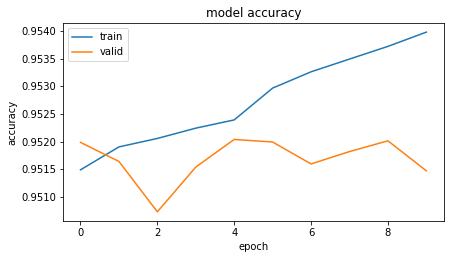

In [30]:
import matplotlib.pyplot as plt

plt.figure(1, figsize = (15,8)) 
    
plt.subplot(222)  
plt.plot(fit_history.history['accuracy'])  
plt.plot(fit_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

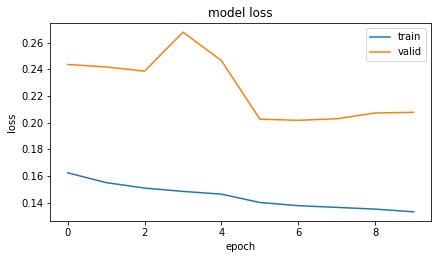

In [31]:
import matplotlib.pyplot as plt

plt.figure(1, figsize = (15,8)) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [33]:
# Guardar el modelo y los pesos
# serializar el modelo a JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serializar los pesos a HDF5
model.save_weights("model.h5")
print("Modelo Guardado!")

Modelo Guardado!


In [34]:
model.save('modelo_completo.h5')

### Prueba del modelo entrenado

En este punto, le mostramos a nuestro modelo entrenado un conjunto de datos nuevo, en este caso el subconjunto de pruebas el cual aun no "conoce", con la intención de comprobar si nuestro modelo puede comportarse adecuadamente con datos nuevos.

* Cargamos el mejor grupo de pesos generado en la fase de entrenamiento

In [35]:
model.load_weights('pesos.h5')

* Usamos nuestro modelo para clasificar imagenes del conjunto de datos de prueba

In [36]:
pred_y = model.predict_generator(test_gen, steps=test_gen.n/test_gen.batch_size, verbose = True)

1035/1034 [==============================] - 608s 588ms/step


In [37]:
score = model.evaluate_generator(test_gen, steps=test_gen.n/test_gen.batch_size)

In [38]:
print("Loss: ", score[0], "Accuracy: ", score[1])

Loss:  0.11620441824197769 Accuracy:  0.951409101486206


In [39]:
mat_pred = np.matrix(pred_y)
with open('predicts.txt','w') as f:
    for line in mat_pred:
        np.savetxt(f, line, fmt='%.8f')

In [59]:
img_path="../input/data/images_011/images/00027533_002.png"

In [60]:
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions


img = image.load_img("../input/data/images_011/images/00027533_002.png", target_size=(224, 224))

# Preprocessing the image
x = image.img_to_array(img)
# x = np.true_divide(x, 255)
x = np.expand_dims(x, axis=0)

# Be careful how your trained model deals with the input
# otherwise, it won't make correct prediction!
x = preprocess_input(x)

preds = model.predict(x)
print(preds)

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [58]:
all_labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [ ]:
pred_y.shape

In [ ]:
pred_y2 = pred_y[0:32]
pred_y2.shape

In [ ]:
import cv2
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import img_to_array

In [ ]:
img_idx = [] #list of random indices
img_path = [] # list of random image paths corresponding to the above indices
all_idx = list(range(test_df.shape[0])) 
for i in range(len(all_labels)):
    idx = np.random.choice(np.argsort(pred_y[:,i])[-100:])
    print(idx,end=" ")
    img_idx.append(idx)
    img_path.append("../input/nih-chest-xrays-224-gray/images/"+test_df["Image Index"].iloc[idx])

In [ ]:
IMG_SIZE = (224, 224)
img_array = []
for i in range(len(all_labels)) :
    cur_path = img_path[i]
    img = cv2.imread(cur_path,0)
    img = cv2.resize(img,IMG_SIZE)
    img_array.append(img_to_array(img,dtype='float32'))
img_array = np.array(img_array)
print(img_array.shape)

In [ ]:
def find_target_layer():
  for layer in reversed(model.layers):
    if len(layer.output_shape) == 4:
      return layer.name

In [ ]:
from keras import Model


In [ ]:
model.inputs

In [ ]:
def gen_heatmap(input_image,target_class):
    target_layer = model.get_layer(find_target_layer())
    gradModel = Model(inputs = [model.inputs],outputs = [target_layer.output, model.output])
    with tf.GradientTape() as tape:
        convOutputs, pred = gradModel(input_image)
        loss = pred[:,target_class]
    grads = tape.gradient(loss, convOutputs)           
    # use automatic differentiation to compute the gradients
    
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads  
    # compute the guided gradients
    
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
    heatmap = cv2.resize(cam.numpy(), IMG_SIZE)
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + epsilon  # normalize the heatmap such that all values lie in the range
    heatmap = numer / denom                            # [0, 1], scale the resulting values to the range [0, 255]
    heatmap = (heatmap * 255).astype("uint8")          # and then convert to an unsigned 8-bit integer
    return heatmap

In [ ]:
fig, axs = plt.subplots(4, 4,figsize=(16,16))
i = 0
j = 0
for k in range(len(all_labels)):
    idx = img_idx[k]
    target = np.argmax(pred_y[idx,:]) # select target class as the one with highest probability
    print(target)
    heatmap = gen_heatmap(img_array[k:k+1],target)
    axs[i,j].imshow(img_array[k,:,:,0].astype("uint8"))
    axs[i,j].imshow(heatmap,alpha=0.5)
    axs[i,j].set_title(all_labels[target]+" : "+str(pred_y[idx,target]))
    j+=1
    if j==4:
        i += 1
        j = 0
fig.savefig("xray_samples.png")

En este punto podemos validar que las prediccíones igualmente están dadas por un vector de enfermedad

In [51]:
test_gen.reset()
test_x, test_y = next(test_gen)
print(f"Vector de enfermedades: {test_y[1]}")
print(f"Vector de enfermedades producto de la predicción: {pred_y[2]}")

Vector de enfermedades: [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Vector de enfermedades producto de la predicción: [2.30770350e-01 1.06170475e-02 1.92451149e-01 5.13930023e-02
 5.51247835e-01 1.85507536e-03 2.88635492e-03 1.12354755e-04
 3.60821426e-01 2.41968632e-02 3.69258523e-02 2.14449167e-02
 2.92054415e-02 3.38714123e-02]


In [ ]:
np.argmax(pred_y[0])

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
plt.matshow(confusion_matrix(test_y, pred_y2>0.5))
print(classification_report(test_y, pred_y2>0.5, target_names = ['Healthy', 'Infiltration']))

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

plt.matshow(confusion_matrix(test_y, pred_y2>0.5))

In [ ]:
from sklearn.metrics import confusion_matrix


#confusion_matrix(test_y, pred_y2>0.5, 4)
from sklearn.metrics import classification_report

print(classification_report(test_y, pred_y2[0], target_names = all_labels))


### Curvas ROC en fase de prueba

Mostramos los resultados de las curvas de ROC  para cada enfermedad, para poder evidenciar los resultados del modelo a la hora de clasificar imágenes del conjunto de datos de prueba.

Estos resultados son nuestro punto de comparación con otros estudios similares.

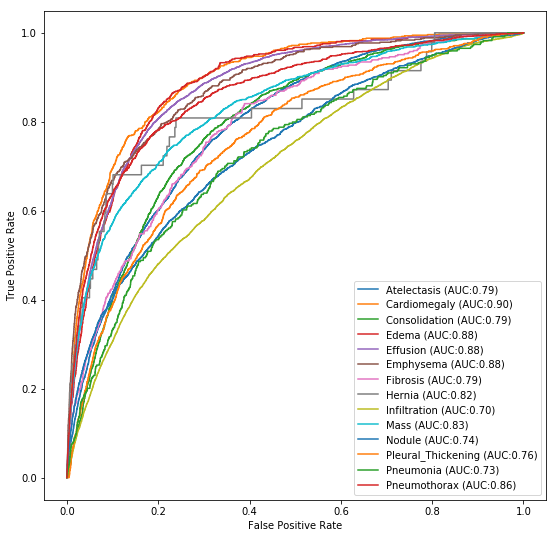

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
test_gen.reset()
test_x, test_y = next(test_gen)
# Space
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    #Points to graph
    fpr, tpr, thresholds = roc_curve(test_gen.labels[:,idx].astype(int), pred_y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    
#convention
c_ax.legend()

#Labels
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')

# Save as a png
fig.savefig('curva_roc.png')

A continuación podemos ver el resultado promedio de las Curvas de ROC

In [53]:
from sklearn.metrics import roc_auc_score
# ROC AUC
auc = roc_auc_score(test_gen.labels, pred_y)
print('ROC AUC: %f' % auc)

ROC AUC: 0.810509


In [ ]:
test_gen.n/test_gen.batch_size

In [ ]:
final_pred_y = model.predict(test_x, batch_size=32, verbose = True)

In [ ]:
import numpy as np
from keras.preprocessing import image

test_image = image.load_img(test_df["Path"].iloc[2], target_size=(224,224))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
result = model.predict(test_image)
print(result)

In [ ]:
import numpy as np
from keras.preprocessing import image

test_image = image.load_img('../input/nih-chest-xrays-224-gray/images/00000001_000.png', target_size=(224,224))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
result = model.predict(test_image) 
print(result)
max_index = np.argmax(result[0], axis=0)
print(max_index)

In [ ]:
pred_y[0]
print(pred_y[25])
max_index = np.argmax(pred_y[25], axis=0)
print(max_index)
print(all_labels)

In [ ]:
final_pred_y

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
#plt.matshow(confusion_matrix(test_y, final_pred_y>0.5))
print(classification_report(test_y, final_pred_y>0.5, target_names = all_labels))

In [ ]:
from sklearn.metrics import recall_score
recall = recall_score(test_y, pred_y2>0.5, average='binary')
print(recall)


# Algunos ejemplos aleatorios de los Resultados
Mostramos algunas imagenes de manera aleatoria, para ejemplificar como puede comportarse la CNN.

Estos resultados no reflejan el desempeño real de la red, pero pueden darnos un vistazo de su comportamiento.

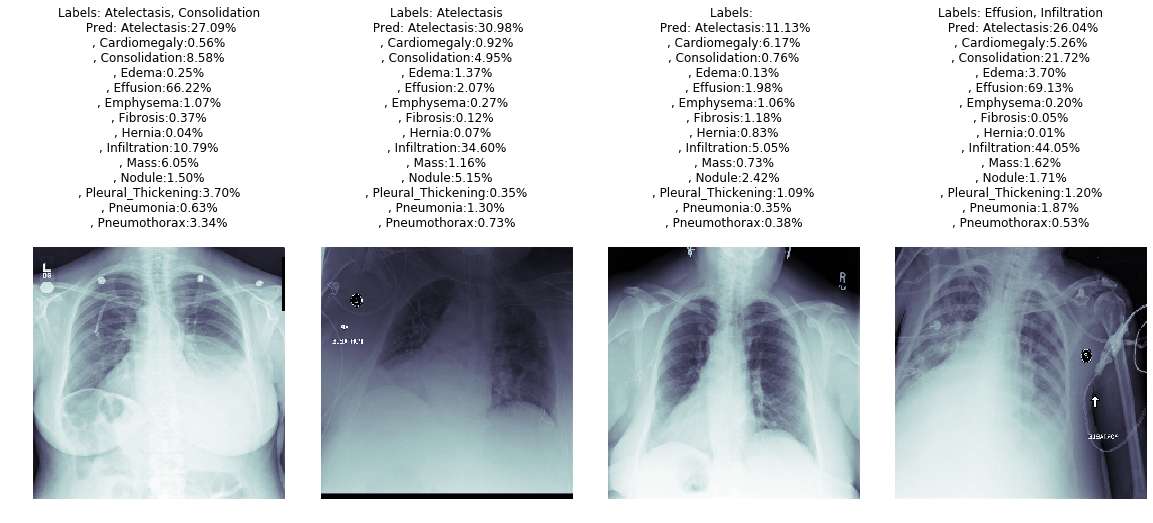

In [54]:
sickest_idx = np.argsort(np.sum(test_y, 1)<1)
sickest_idx = [10,21,25,18]
#Space of images
fig, m_axs = plt.subplots(1, 4, figsize = (16, 16))

# Padding
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)
counter = 0

for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):
    
    # Image show
    c_ax.imshow(test_x[idx, :,:,0], cmap = 'bone')
    
    stat_str = [n_class for n_class, n_score in zip(all_labels, test_y[idx]) if n_score>0.5]
        
    # Building the labels
    pred_str = [f'{n_class}:{p_score*100:.2f}%\n' 
                for n_class, n_score, p_score 
                in zip(all_labels,test_y[idx],pred_y[idx]) ]
    
    c_ax.set_title(f'Labels: '+', '.join(stat_str)+'\n Pred: '+', '.join(pred_str))
    c_ax.axis('off')
fig.savefig('predicciones.png')